In [106]:

#Load libraries
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
import joblib


# Suppress warnings
warnings.filterwarnings("ignore")

In [107]:
#load data from source
#Data source from kraggle.com
#link: https://www.kaggle.com/datasets/mikhail1681/walmart-sales/data
df = pd.read_csv("C:/Users/DELL/Desktop/DINNO/Python_Project/Walmart_Sales_Modelling/Walmartsales.csv")

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [109]:
# Define and store the FuncFormatter for y axis value and use when needed

from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    if value >= 1_000_000:
        value /= 1_000_000
        return f'${value:.0f}M'
    elif value >= 1_000:
        value /= 1_000
        return f'${value:.0f}K'
    else:
        return f'${value:.0f}'

In [110]:
wk_df = df

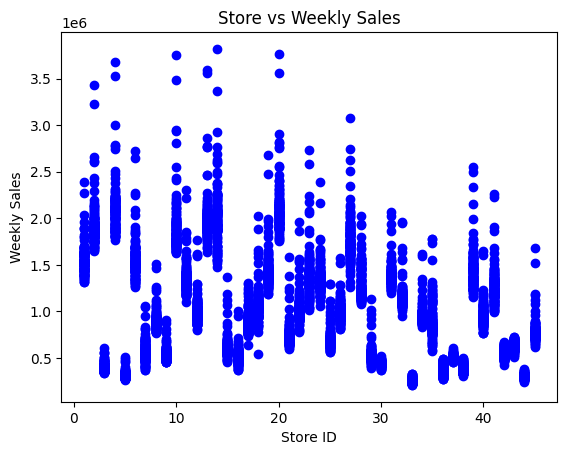

In [111]:
plt.scatter(wk_df['Store'], wk_df['Weekly_Sales'], color='blue')
plt.xlabel('Store ID')
plt.ylabel('Weekly Sales')
plt.title('Store vs Weekly Sales')
plt.show()

In [112]:

# Select features
features = ['Weekly_Sales', 'Store']

# Splitting the data into train and test sets
X_train, X_test = train_test_split(wk_df[features], test_size=0.2, random_state=42)

# Create an Isolation Forest model
isolation_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit the model to the training data
isolation_forest.fit(X_train)

# Predict anomalies on the test set
X_test['Spike'] = isolation_forest.predict(X_test)

# Filter spikes (anomalies)
Spikes = X_test[X_test['Spike'] == -1]

# Save the trained model to a file
joblib.dump(isolation_forest, 'isolation_forest_model.pkl')

['isolation_forest_model.pkl']

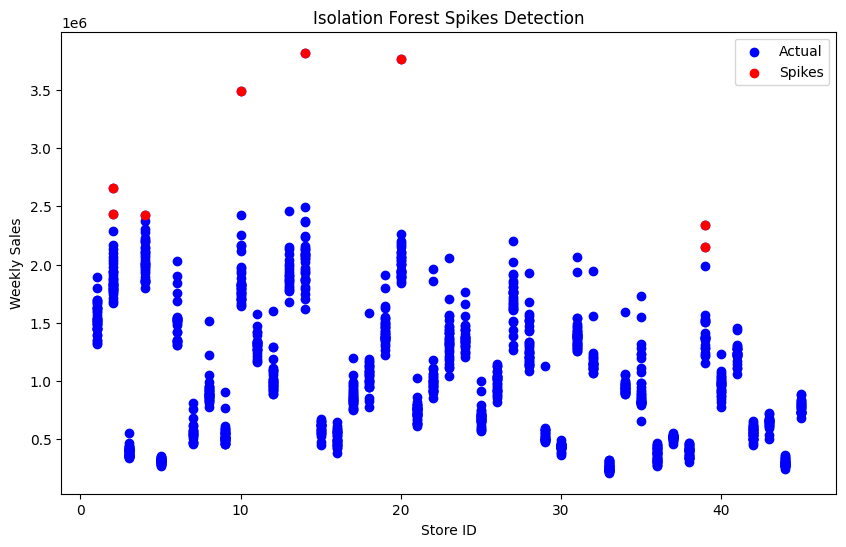

In [113]:
#Visualization of Actual weekly sales and Predicted weekly sales Spikes

# Plotting Weekly_Sales against Store
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Store'], X_test['Weekly_Sales'], c='blue', label='Actual')
plt.scatter(Spikes['Store'], Spikes['Weekly_Sales'], c='red', label='Spikes')
plt.xlabel('Store ID')
plt.ylabel('Weekly Sales')
plt.title('Isolation Forest Spikes Detection')
plt.legend()
plt.show()


In [114]:
# Load the saved model from file
isolation_forest_loaded = joblib.load('isolation_forest_model.pkl')

features = ['Weekly_Sales', 'Store']

# Predict anomalies on the entire dataset
wk_df['Spike'] = isolation_forest_loaded.predict(wk_df[features])

# Filter out the spikes (anomalies)
spikes = wk_df[wk_df['Spike'] == -1]


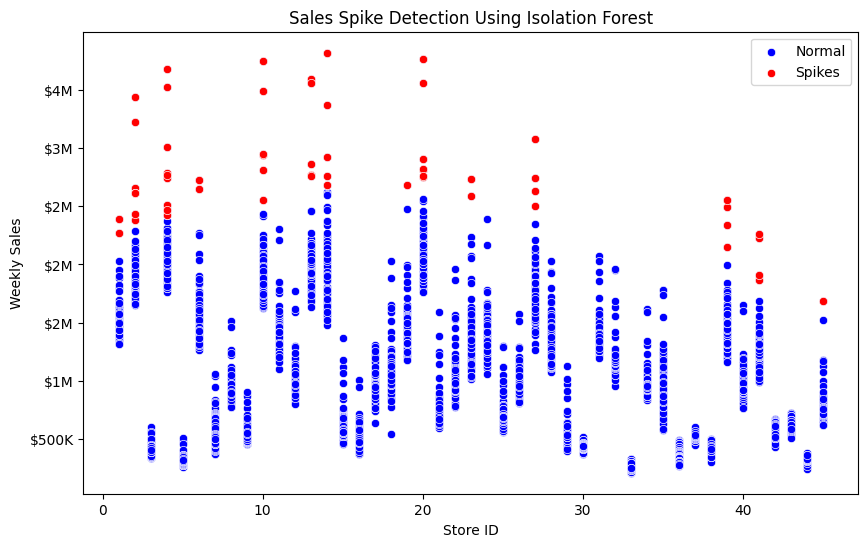

In [115]:
# Plotting the entire dataset with Spikes highlighted
plt.figure(figsize=(10, 6))

# Plotting normal data points
sns.scatterplot(data=wk_df, x='Store', y='Weekly_Sales', color='blue', label='Normal')

# Highlighting Spikes
Spikes = wk_df[wk_df['Spike'] == -1]
sns.scatterplot(data=Spikes, x='Store', y='Weekly_Sales', color='red', label='Spikes')

plt.title('Sales Spike Detection Using Isolation Forest')
plt.xlabel('Store ID')
plt.ylabel('Weekly Sales')
plt.legend()

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()


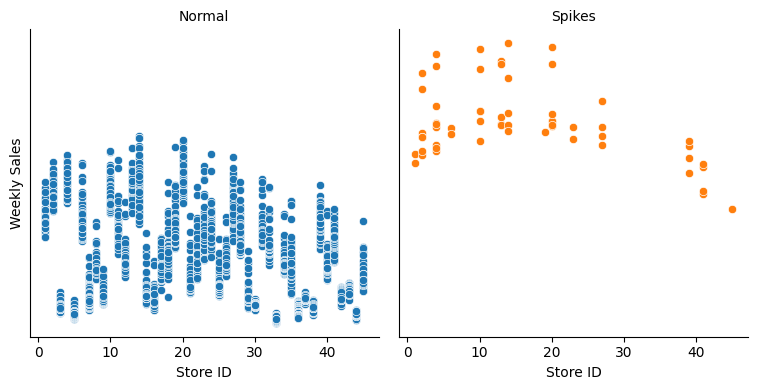

In [116]:
# Map -1 to 'Spike Sales' and 1 to 'N'
wk_df['Spike_Label'] = wk_df['Spike'].map({-1: 'Spikes', 1: 'Normal'})

# Create a FacetGrid
g = sns.FacetGrid(wk_df, col='Spike_Label', hue='Spike_Label', height=4, hue_order=['Normal', 'Spikes'])

# Map the scatter plot to visualize anomalies
g.map(sns.scatterplot, 'Store', 'Weekly_Sales')

# Add titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Store ID", "Weekly Sales")
g.set(yticklabels=[])
g.set(yticks=[])
plt.show()


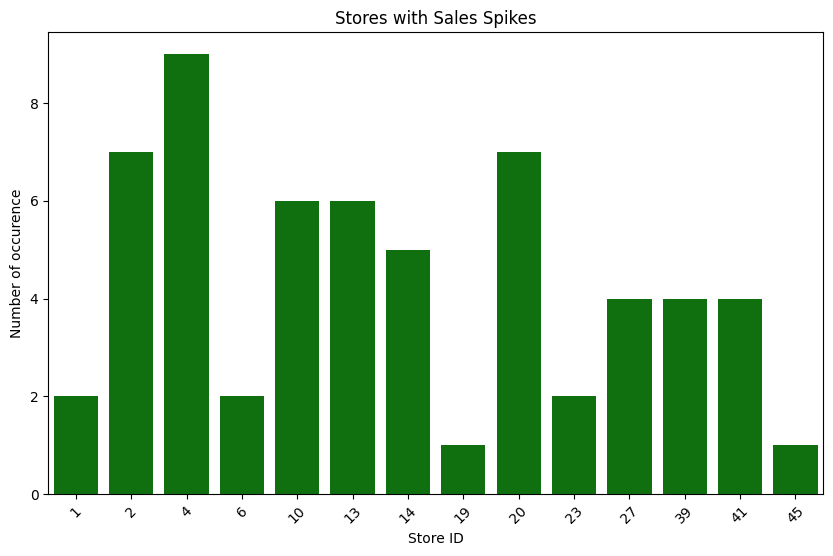

In [117]:
# Get high sales detected by the Isolation Forest model
Spikes = wk_df[wk_df['Spike'] == -1]

# Plotting only the anomalies by store
plt.figure(figsize=(10, 6))
sns.countplot(data=Spikes, x='Store', color='green')
plt.title('Stores with Sales Spikes')
plt.xlabel('Store ID')
plt.ylabel('Number of occurence')
plt.xticks(rotation=45)
plt.show()


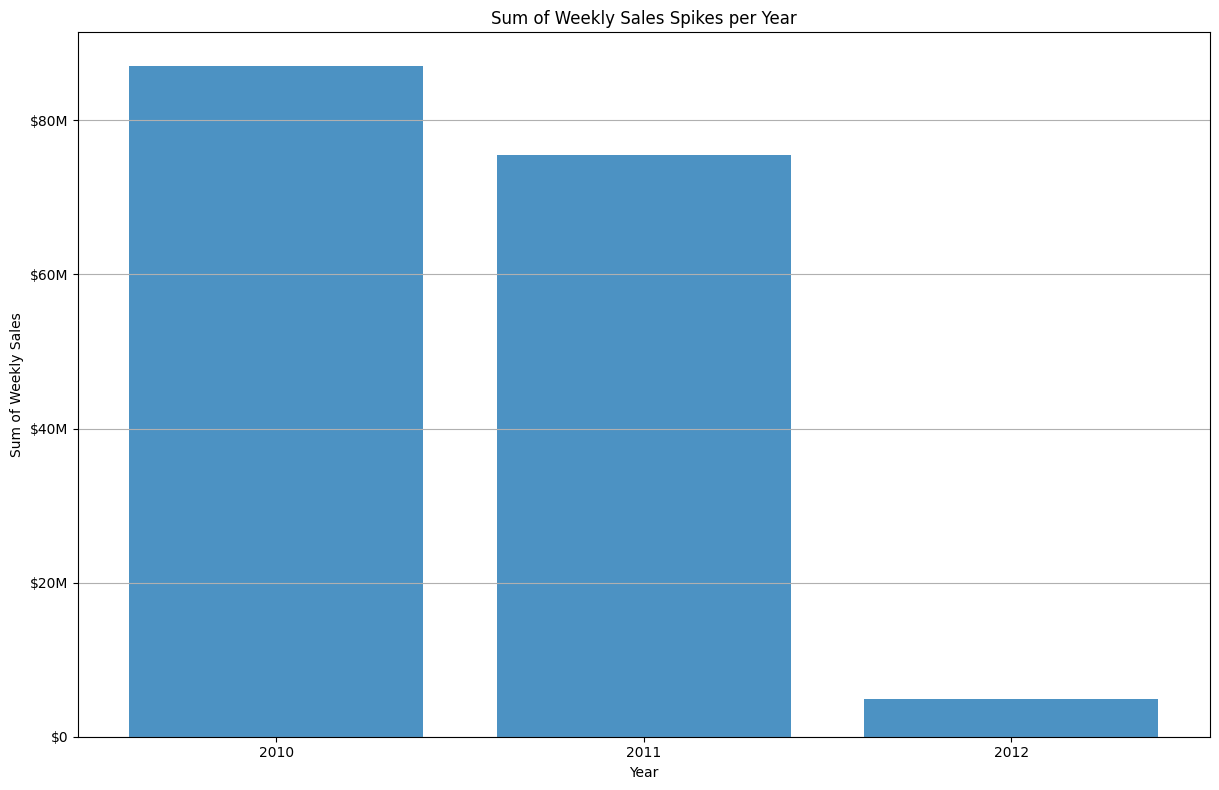

167473735.52
        Date  Weekly_Sales
0 2010-12-31   87079848.03
1 2011-12-31   75496041.19
2 2012-12-31    4897846.30


In [118]:
# Convert 'Date' column to datetime format if it's not already
wk_df['Date'] = pd.to_datetime(wk_df['Date'])

# Filter the data to include only rows where 'Spike' is -1
spike_data = wk_df[wk_df['Spike'] == -1]

# Group by 'Date' (yearly frequency) and sum 'Weekly_Sales'
spike_sales_per_year = spike_data.groupby(pd.Grouper(key='Date', freq='Y'))['Weekly_Sales'].sum().reset_index()
Total_spikes_sales = spike_data['Weekly_Sales'].sum()
# Plotting a bar chart for sum of weekly sales spikes per year
plt.figure(figsize=(12, 8))

plt.bar(spike_sales_per_year['Date'].dt.year, spike_sales_per_year['Weekly_Sales'], alpha=0.8)

plt.title('Sum of Weekly Sales Spikes per Year')
plt.xlabel('Year')
plt.ylabel('Sum of Weekly Sales')
plt.xticks(spike_sales_per_year['Date'].dt.year)
plt.grid(axis='y')
plt.tight_layout()

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()
print (Total_spikes_sales)
print(spike_sales_per_year)

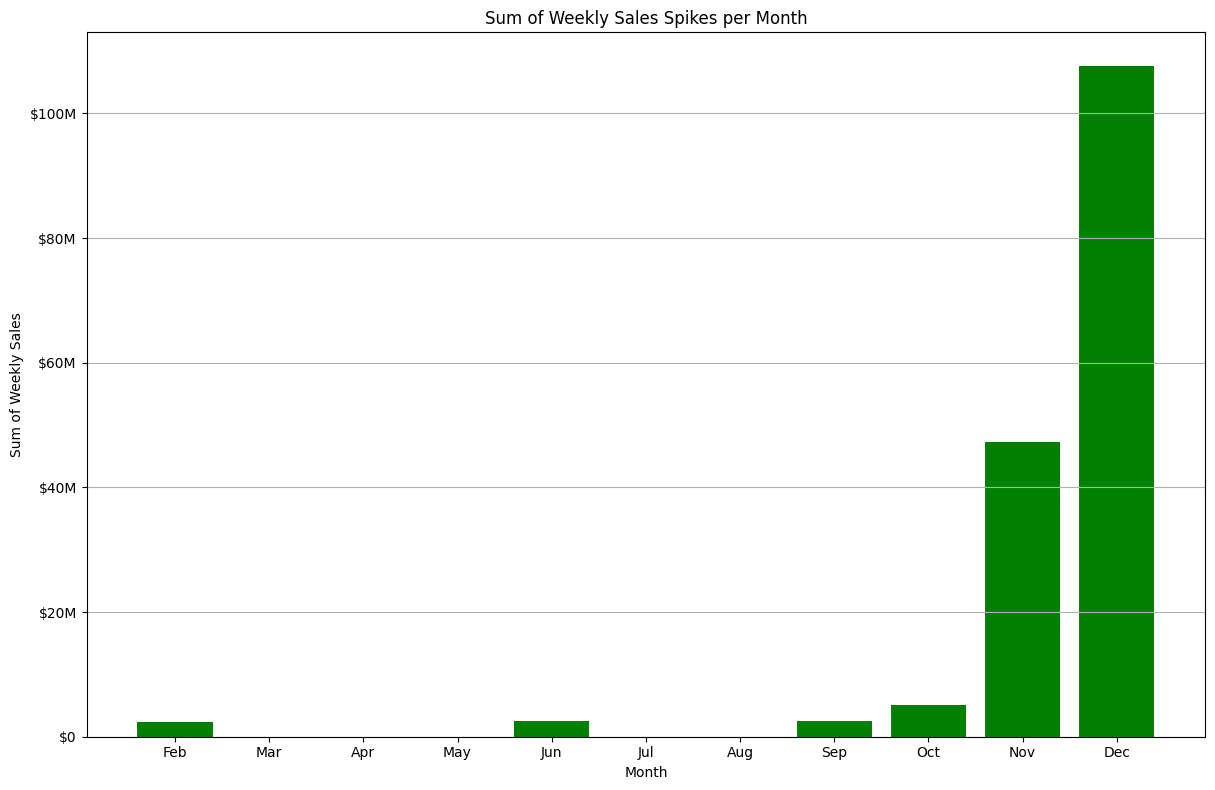

In [119]:
# Filter the data to include only rows where 'Spike' is -1
spike_data = wk_df[wk_df['Spike'] == -1]

# Extract month names for grouping
spike_data['Month'] = spike_data['Date'].dt.strftime('%b')

# Group by 'Month' and sum 'Weekly_Sales'
spike_sales_per_month = spike_data.groupby('Month')['Weekly_Sales'].sum().reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']).reset_index()

# Plot bar chart for sum of weekly sales spikes per month
plt.figure(figsize=(12, 8))
plt.bar(spike_sales_per_month['Month'], spike_sales_per_month['Weekly_Sales'], color = 'green')

plt.title('Sum of Weekly Sales Spikes per Month')
plt.xlabel('Month')
plt.ylabel('Sum of Weekly Sales')
plt.grid(axis='y')
plt.tight_layout()

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()

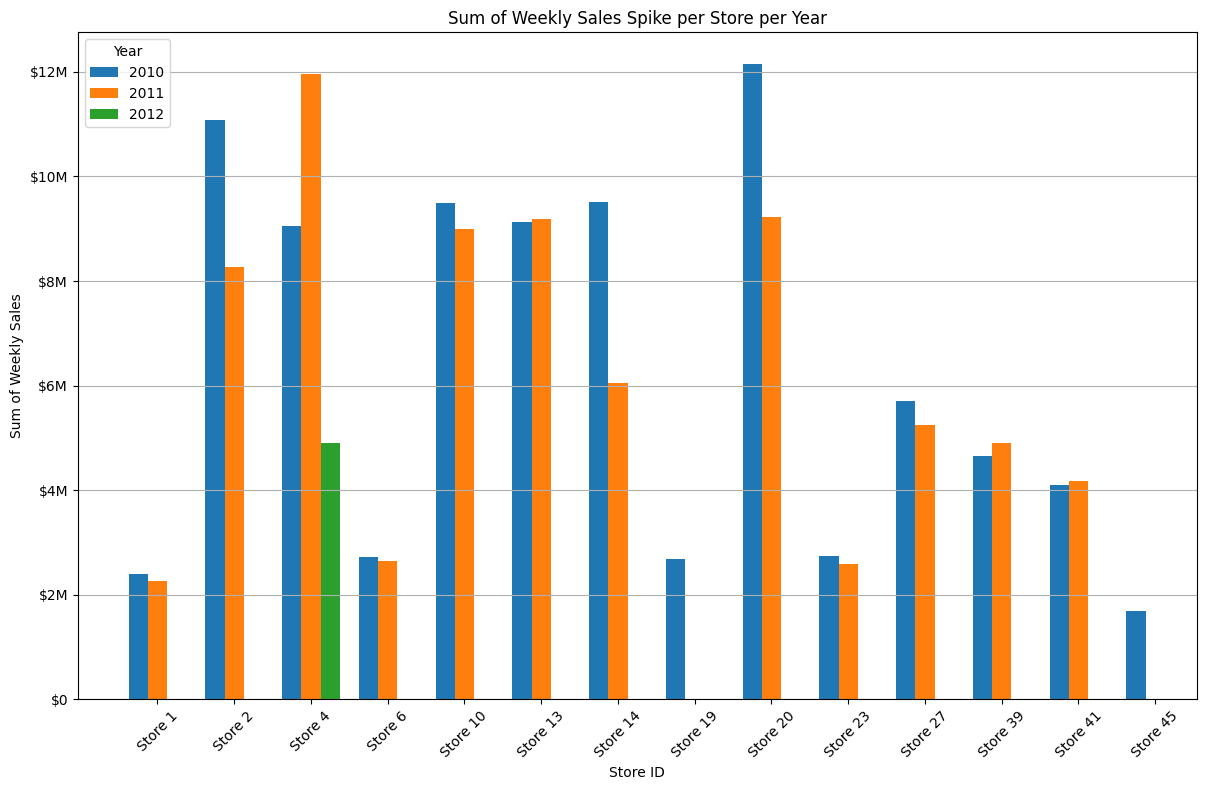

In [120]:

# Filter the data to include only rows where 'Spike' is -1
spike_data = wk_df[wk_df['Spike'] == -1]

# Group by 'Store', 'Date' (yearly frequency), and sum 'Weekly_Sales'
spike_sales_per_store_per_year = spike_data.groupby(['Store', pd.Grouper(key='Date', freq='Y')])['Weekly_Sales'].sum().reset_index()

# Pivot the data to have years as columns for each store
spike_sales_pivot = spike_sales_per_store_per_year.pivot(index='Store', columns='Date', values='Weekly_Sales')

# Get the available years (columns) with data
available_years = spike_sales_pivot.columns

# Plot bar chart for each year showing sales per store
plt.figure(figsize=(12, 8))

# Ensure stores are treated as categorical variables
stores = spike_sales_pivot.index

# Number of years
num_years = len(available_years)

# Bar width
bar_width = 1.0 / (num_years + 1)

# Iterate over each year to plot bars for each store
for i, year in enumerate(available_years):
    plt.bar([store + i * bar_width for store in range(len(stores))], 
            spike_sales_pivot[year], 
            width=bar_width, 
            label=year.year)

plt.title('Sum of Weekly Sales Spike per Store per Year')
plt.xlabel('Store ID')
plt.ylabel('Sum of Weekly Sales')
plt.xticks([store + bar_width * (num_years - 1) / 2 for store in range(len(stores))], 
           labels=[f'Store {store}' for store in stores], rotation=45)
plt.legend(title='Year')
plt.grid(axis='y')
plt.tight_layout()

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()


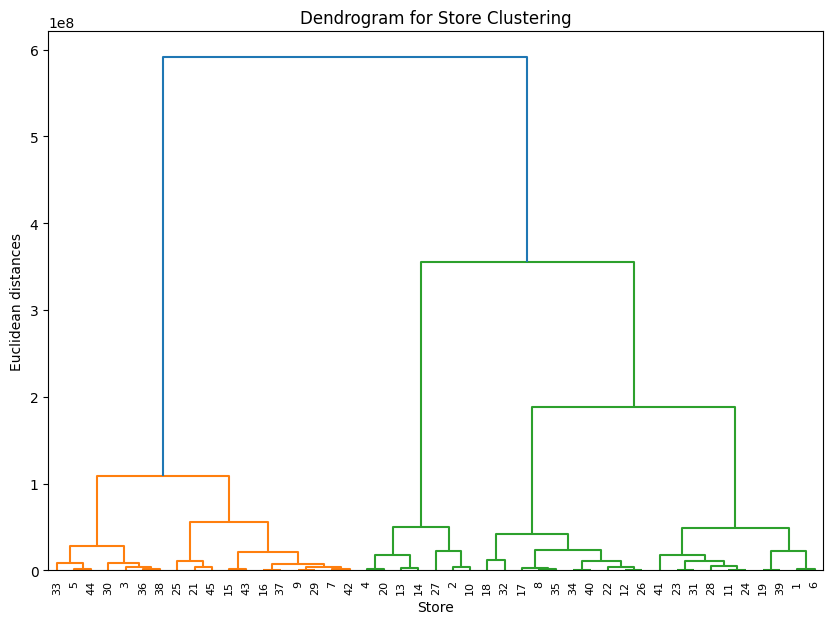

In [121]:
# Store Segmentation
# Hierachical Clustering

store_sales = wk_df.groupby('Store')['Weekly_Sales'].sum().reset_index()

# data standardization
scaler = StandardScaler()
store_sales['Sales_Scaled'] = scaler.fit_transform(store_sales[['Weekly_Sales']])

# Hierarchical Clustering
Z = linkage(store_sales['Weekly_Sales'].values.reshape(-1, 1), method='ward')

# Ploting of Dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram for Store Clustering")
plt.xlabel("Store ID")
plt.ylabel("Euclidean distances")
dendrogram(Z, labels=store_sales['Store'].values)
plt.show()


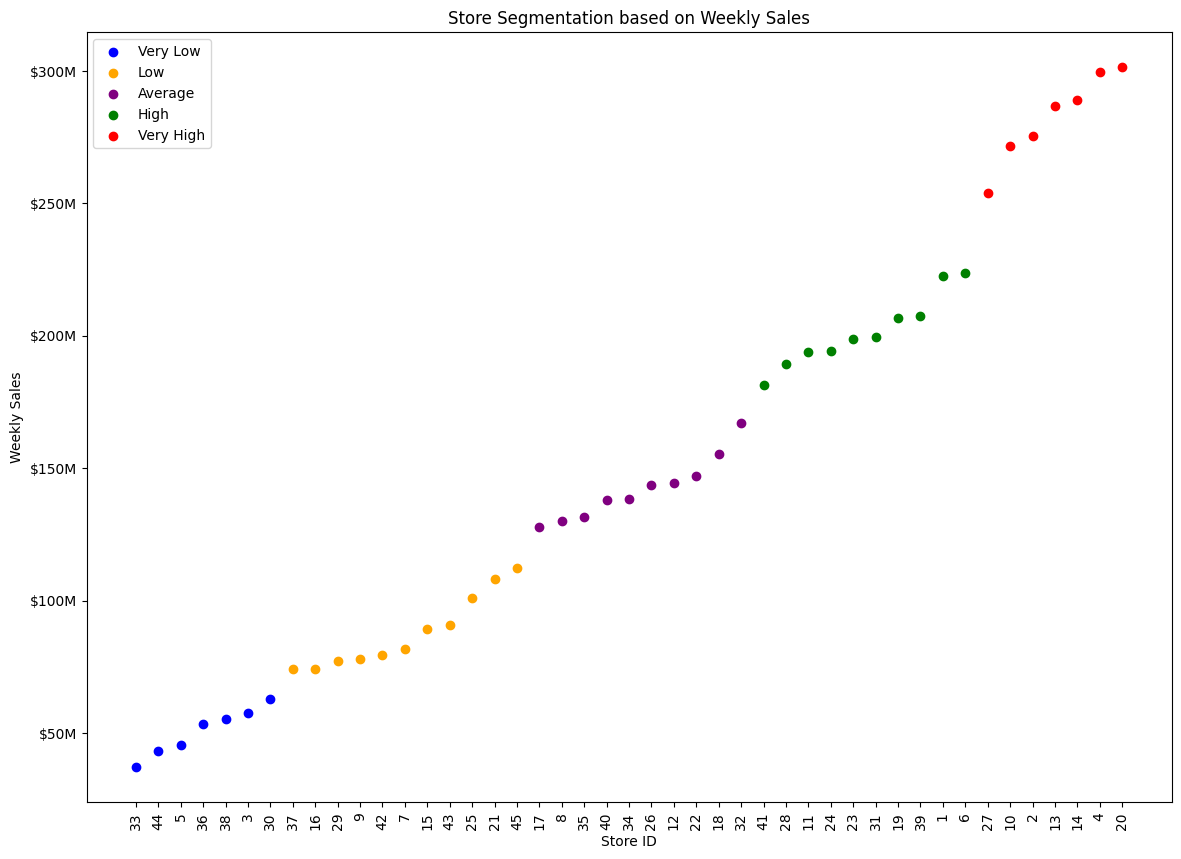

In [122]:
# Store Clasification
# categorize to 5 clusters i.e, very low, low, average, high, very high)
max_d = 5
clusters = fcluster(Z, max_d, criterion='maxclust')

# Adding the cluster information to the DataFrame
store_sales['Cluster'] = clusters

# Sort clusters and assign labels by mean sales
cluster_sales_mean = store_sales.groupby('Cluster')['Weekly_Sales'].mean().sort_values()
cluster_labels = {cluster: label for cluster, label in zip(cluster_sales_mean.index, ['Very Low', 'Low', 'Average', 'High', 'Very High'])}

store_sales['Cluster_Label'] = store_sales['Cluster'].map(cluster_labels)
store_sales = store_sales.sort_values(by=['Cluster', 'Weekly_Sales'])

# Plotting the clusters distribution
plt.figure(figsize=(14, 10))
colors = ['blue', 'orange', 'red', 'purple', 'green'] 

for cluster, label in cluster_labels.items():
    clustered_data = store_sales[store_sales['Cluster'] == cluster]
    plt.scatter(clustered_data['Store'].astype(str), clustered_data['Weekly_Sales'], label=label, color=colors[cluster-1])

# Set the x-axis with the store labels in the sorted order
plt.xticks(store_sales['Store'].astype(str), rotation=90)

plt.title('Store Segmentation based on Weekly Sales')
plt.xlabel('Store ID')
plt.ylabel('Weekly Sales')
plt.legend()

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()